In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import cross_validation
from sklearn.base import TransformerMixin

from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

stop_words = stopwords.words('english')

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Токенизация с удалением знаков препинания
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

#Токенизация с оставленными знаками препинания
def tokenize2(text):
    text = text.lower()
    return wordpunct_tokenize(text)

In [3]:
#Длина текста
def length(text):
    return len(text)

#Количество восклицательных знаков
def exclamation(text):
    """Сколько !."""
    return len([letter for letter in list(text) if letter == '!'])

#Количество чисел
def numbers(text):
    return len([letter for letter in list(text) if letter.isdigit()])

#Количество типичных для спам-сообщений слов
def warning_words(text):
    return len([word for word in tokenize(text) if word in spam_words])

#Вышеперечисленные фичи формируют Featurizer
class FunctionFeaturizer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fvs = []
        for datum in X:
            fv = [f(datum) for f in self.featurizers]
            fvs.append(fv)
        return np.array(fvs)

In [4]:
spam_featurizer = FunctionFeaturizer(length, exclamation, numbers, warning_words)  # создание своего векторизатора

path = 'D:\\SMSSpamCollection'

# Чтение из файла
messages = pandas.read_csv(path, sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
messages['length'] = messages['message'].map(lambda text: len(text))

In [6]:
# Топ-50 спам-слов по частотности
from collections import Counter
list1 =[]
for m in messages.message[messages.label=='spam']:
    for word in tokenize(m):
        list1.append(word)
counts = Counter(list1)

counts.most_common(50)

[('.', 924),
 ('to', 690),
 ('!', 545),
 (',', 378),
 ('a', 377),
 ('call', 346),
 ('you', 297),
 ('your', 263),
 ('free', 217),
 ('the', 206),
 ('for', 203),
 ('now', 199),
 ('or', 188),
 ('&', 178),
 ('?', 175),
 ('2', 174),
 (':', 163),
 ('is', 158),
 ('txt', 156),
 ('on', 145),
 ('ur', 144),
 ('u', 141),
 ('have', 136),
 ('from', 131),
 ('mobile', 123),
 ('and', 122),
 ('text', 121),
 ('stop', 118),
 ('claim', 113),
 ('with', 109),
 ('reply', 104),
 ('4', 95),
 ('of', 95),
 ('prize', 92),
 ('this', 88),
 ('our', 85),
 ('get', 84),
 ('are', 80),
 ('only', 79),
 ('just', 79),
 ('in', 73),
 ('won', 73),
 ("'s", 72),
 ('send', 69),
 ('new', 69),
 ('t', 68),
 (')', 66),
 ('nokia', 65),
 ('urgent', 63),
 ('cash', 62)]

In [7]:
#Насколько сбалансирован датасет?
messages.groupby('label').describe()
#хм... не очень сбалансирован. 4825 не-спама к 747 спама

length
label                   
ham   count  4825.000000
      mean     71.482487
      std      58.440652
      min       2.000000
      25%      33.000000
      50%      52.000000
      75%      93.000000
      max     910.000000
spam  count   747.000000
      mean    138.670683
      std      28.873603
      min      13.000000
      25%     133.000000
      50%     149.000000
      75%     157.000000
      max     223.000000

In [8]:
#Переводим str в int и ham/spam в 0/1
messages['label'] = messages['label'].map({'ham': 0, 'spam': 1}).astype(int)

In [9]:
#  Тренировочная выборка/Тестовая выборка 80 к 20
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

In [10]:
# Векторизация
bow = CountVectorizer()
bow.fit_transform(msg_train)
train_bowed_messages = bow.transform(msg_train)
test_bowed_messages = bow.transform(msg_test)

In [11]:
#Dummy Classifier + результаты
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(train_bowed_messages, label_train)

print(classification_report(label_test, clf.predict(test_bowed_messages)))
#Если я правильно понял, то класификатор тупо помечает все сообщения как не-спам и благодаря этому у него получается такой
#высокий precision. Гениально(на самом деле ужасно)

             precision    recall  f1-score   support

          0       0.86      1.00      0.92       956
          1       0.00      0.00      0.00       159

avg / total       0.74      0.86      0.79      1115



D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
#Naive Bayes
naive_model = MultinomialNB()
naive_model.fit(train_bowed_messages, label_train)

cv_results = cross_val_score(naive_model, test_bowed_messages, label_test, cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(label_test, naive_model.predict(test_bowed_messages)))
#вот это очень хорошо

0.968653328653 0.0170837384797
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       956
          1       0.95      0.89      0.92       159

avg / total       0.98      0.98      0.98      1115



In [13]:
def trainmodel(steps):
    pipeline = Pipeline(steps=steps)

    cv_results = cross_val_score(pipeline,
                                 msg_train,
                                 label_train,
                                 cv=10,
                                 scoring='accuracy',
                                 )
    print(cv_results.mean(), cv_results.std())

    pipeline.fit(msg_train, label_train)
    label_predicted = pipeline.predict(msg_test)
    print(label_predicted)

    print(classification_report(label_test, label_predicted ))

    return pipeline, label_predicted

In [14]:
def draw_learning_curve(pipeline):
    train_sizes, train_scores, valid_scores = learning_curve(pipeline, 
                                                             msg_train, 
                                                             label_train,
                                                             train_sizes=[50, 80, 110], 
                                                             cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)

    plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [15]:
def draw_roc_curve(label_predicted):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(label_test, label_predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

0.984520064984 0.00406243315594
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       956
          1       0.95      0.89      0.92       159

avg / total       0.98      0.98      0.98      1115



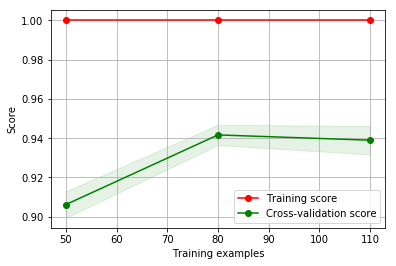

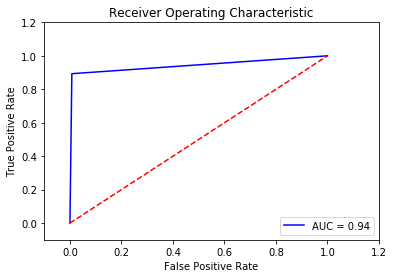

In [16]:
# Токенизация с удаленными знаками препинания, Naive Bayes
pipeline, label_predicted = trainmodel(steps=[('bow', CountVectorizer(analyzer=tokenize)),('classifier', MultinomialNB())])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)
#Судя по roc-curve, классификатор показывает высокие результаты,
#AUC-value очень высокий, roc-curve почти параллельна оси х.
#Learning curve показывает, что при увеличении обучающих данных, cross-validation score может незначительно улучшиться,
#training score при этом не изменится (останется максимальным)

In [17]:
#  Naive Bayes, токенизация с оставленными знаками препинания
pipeline, label_predicted = trainmodel(steps=[('bow', CountVectorizer(analyzer=tokenize2)),('classifier', MultinomialNB())])
#Точность и полнота при поиске спама высоки: в 98% случаев то, что было помечено спамом - будет спамом
#95% recall спама говорит о том, что классификатор отловил 95% спам-сообщений

0.989680043322 0.00377640810895
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       956
          1       0.97      0.91      0.94       159

avg / total       0.98      0.98      0.98      1115



In [18]:
#  Naive Bayes, токенизация без знаков препинания,, стоп-слова удалены
pipeline, label_predicted = trainmodel(steps=[('bow', CountVectorizer(analyzer=tokenize, stop_words=stop_words)),('classifier', MultinomialNB())])
#recall чуть хуже, остальные параметры тоже, но это все равно высокий результат. 
#Судя по среднему числу, удаление стоп-слов пошло на пользу. С другой стороны, существенная разница лишь в recall спама

0.984520064984 0.00406243315594
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       956
          1       0.95      0.89      0.92       159

avg / total       0.98      0.98      0.98      1115



In [19]:
# Naive Bayes, TfIdf-Vectorizer
pipeline, label_predicted = trainmodel(steps=[('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('classifier', MultinomialNB())])
#хуже, чем CountVectorizer

0.959168097659 0.00662123491332
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       956
          1       1.00      0.69      0.81       159

avg / total       0.96      0.96      0.95      1115



0.964553303492 0.00793423766228
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       956
          1       0.89      0.85      0.87       159

avg / total       0.96      0.96      0.96      1115



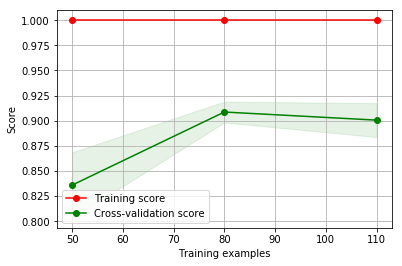

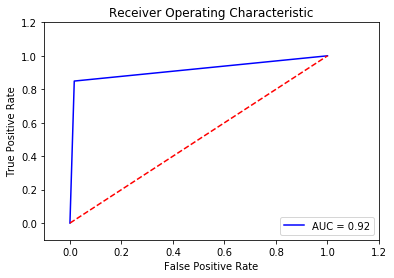

In [20]:
# Decision tree, tf-idf
pipeline, label_predicted = trainmodel(steps=[('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('classifier', DecisionTreeClassifier())])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)
#Learning curve показывает, что увеличение обучающих данных практически ничего не даст. 
#AUC-value равен достаточно высокий, но хуже, чем у Naive Bayes и Random Forest
#В отличие от остальных вариантов, cross-validation score имеет другую форму: сначала "проседает" при росте количества обучающих данных
#а потом лишь чуть-чуть улучшается по сравнению со стартовым количеством\

0.970388955237 0.0065428039054
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       956
          1       1.00      0.74      0.85       159

avg / total       0.96      0.96      0.96      1115



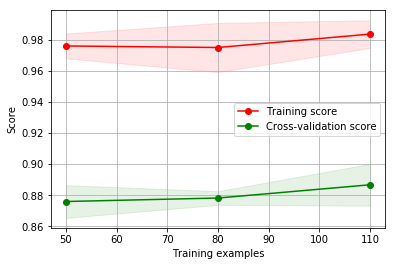

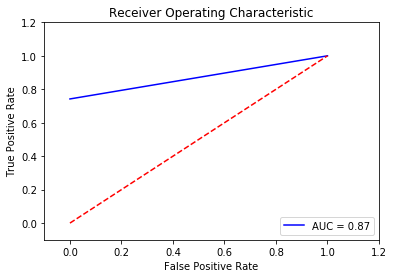

In [21]:
# Random Forest, tf-idf
pipeline, label_predicted = trainmodel(steps=[('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('classifier', RandomForestClassifier())])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)
#Заметный рост cross-validation score до 80 обучающих примеров, затем стагнация(после этого чуть-чуть увеличивается training score)

In [ ]:
#Итоги: Naive Bayes - лучший. Random Forest и Naive Bayes с tf-idf Vectorizer имеют лучшую точность вычисления спама(precision).
#Хуже всего работает Decision Tree с tf-idf. Если судить по средним результатам, то лучше всего работает Naive Bayes.
#В целом, все эти сравнения не сильно существенны, так как все варианты показывают хорошие результаты.